<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/True_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define path to Dataset.zip
zip_path = "/content/drive/My Drive/Dataset.zip"

# Extract Dataset.zip
extract_path = "/content/Dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully!


In [12]:
# Image data generator for training, validation, and testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# Define data_dir
data_dir = "/content/Dataset/Dataset" # Assuming your dataset is in '/content/Dataset'

train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'Training'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'Validation'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'Testing'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 62 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Freeze base layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [14]:
# Train model
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Added compile step
model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

# Save model
model.save('currency_detector.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5108 - loss: 0.7462 - val_accuracy: 0.5556 - val_loss: 1.0943
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5961 - loss: 0.6858 - val_accuracy: 0.5556 - val_loss: 1.5964
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7172 - loss: 0.5821 - val_accuracy: 0.5556 - val_loss: 1.1403
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8293 - loss: 0.4731 - val_accuracy: 0.5556 - val_loss: 0.9699
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7450 - loss: 0.6763 - val_accuracy: 0.5556 - val_loss: 1.0017
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8369 - loss: 0.4544 - val_accuracy: 0.5556 - val_loss: 1.1345
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6707 - loss: 0.5370 - val_accuracy: 0.5556 - val_loss: 1.2584


In [15]:
# Load and test a new image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=[0, -1])
    return img

def predict_currency(image_path, model):
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]
    return 'Real' if prediction < 0.5 else 'Fake'

# Feature extraction - HSV decomposition
def extract_hsv_features(image_path):
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)
    return h, s, v


In [16]:
# Edge detection
def detect_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    return edges

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5000 - loss: 0.9370
Test Accuracy: 50.00%


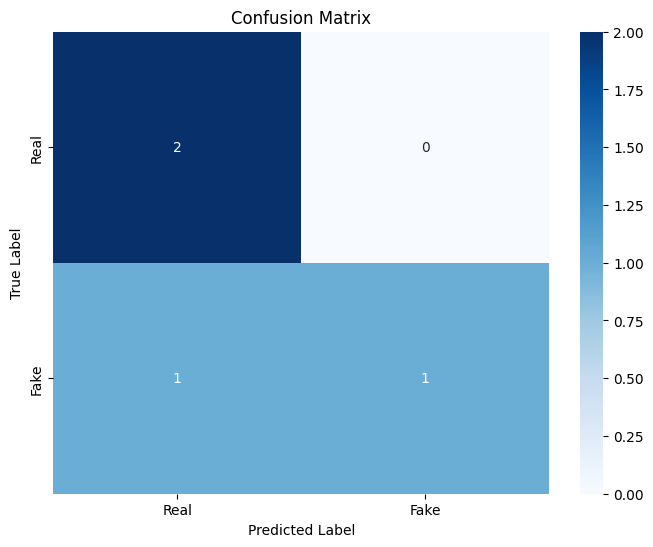

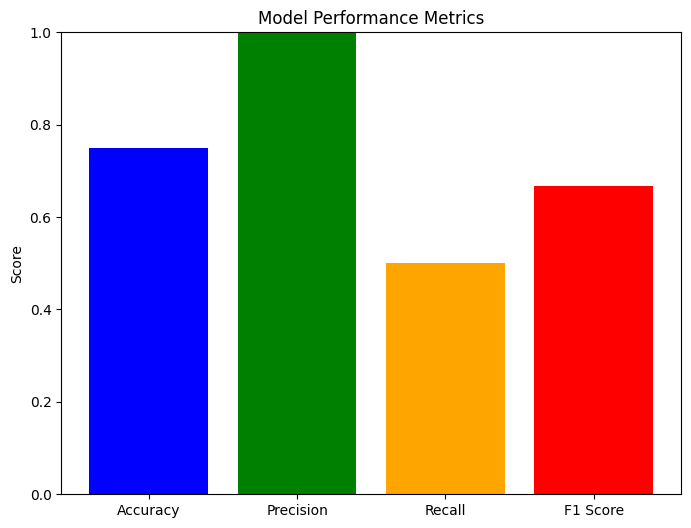

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ... (Your existing code to calculate metrics) ...

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Bar Chart for Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title("Model Performance Metrics")
plt.ylim([0, 1])  # Set y-axis limits for better visualization
plt.ylabel("Score")
plt.show()

In [18]:
import cv2
import numpy as np
import tensorflow as tf
import os

# ... (Your existing code) ...

# Load and test a new image
def preprocess_image(image_path):
    """Preprocesses the image for prediction."""
    # Check if the image file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        raise IOError(f"Failed to load image: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_currency(image_path, model):
    """Predicts the currency class of the image."""
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]
    return 'Real' if prediction < 0.5 else 'Fake'

# Example usage:
image_path = '/content/Dataset/Dataset/Testing/Real/Real.jpg'  # Replace with the path to your image
# Check if the image file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

prediction = predict_currency(image_path, model)
print(f"Prediction for {image_path}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
Prediction for /content/Dataset/Dataset/Testing/Real/Real.jpg: Fake
